### Reasons why the two time-series are cointegrated:

Instead of arguing why your code might be incorrect (*I couldn't find any major mistakes*), I'll argue that there is a possibility the two series are cointegrated -- atleast over some finite interval -- which can be based on some common empirical observations:

- **Cryptocurrencies are affected by the same external events:** Much of the news regarding the general cryptocurrency space affects the direction of all altcoins to a similar extent. While bitcoin, being sometimes synonymously used instead of cryptocurrency, always takes the biggest hit,  Ethereum, does not avoid any negative consequences either. As such they move in tangent based on the outcome of the external market factors.  
- **Altcoins tend to follow BTC:** Bitcoin being the most popular and most traded (*on average*) cryptocurrency tend to affect the outcome of other altcoins. This is very much due to the risk spillover effect: an isolated bitcoin event might affect other altcoins in the future, as such, people tend to flee the cryptocurrency market and reinvest their money in a safe-haven asset outside of the cryptocurrency space. 

Isolated single-coin market events, either news only affecting bitcoin/ethereum or intraday market events (*ie. whales selling out*), might be one of the few factors that are able to break the cointegrational relationship between BTC and ETH. As such, the best way to understand the "opportunity" of the cointegraitonal relationsghip is to employ an analysis on the spread between the two altcoins.    


In [2]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.tsa.stattools as ts
import pandas_ta as ta
import ccxt
import seaborn as sns
#from pykalman import KalmanFilter


#Exchange is FTX:
ftx = ccxt.ftx()

In [52]:

def get_ohlc_ccxt(market, timeframe):
    data = ftx.fetch_ohlcv(market, timeframe, limit=5000)
    ohlcv = pd.DataFrame(data, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
    ohlcv = ohlcv.drop_duplicates(subset=['time', 'open', 'high', 'low', 'close', 'volume'], keep='first')
    ohlcv['time'] = ohlcv['time'].astype('int64')
    ohlcv['time'] = ohlcv['time']/1000
    ohlcv = ohlcv.set_index(pd.to_datetime(ohlcv['time'], unit='s'))
    ohlcv.index.names = ['date']
    ohlcv = ohlcv.drop(['time'], axis = 1)
    return ohlcv


def check_pair(first_market, second_market, timeframe):
    first = get_ohlc_ccxt(first_market, timeframe)
    second = get_ohlc_ccxt(second_market, timeframe)

    if len(first) != len(second):
        length = min(len(first), len(second))
        first = first.iloc[-length:]
        second = second.iloc[-length:]

    x = first['close'].to_numpy()
    y = second['close'].to_numpy()
    
    first['logret'] = first.ta.log_return()
    second['logret'] = second.ta.log_return()

    xr = first['logret'].dropna()
    yr = second['logret'].dropna()

    coint = ts.coint(xr.to_numpy(), yr.to_numpy())
    p_value = coint[1]

    print('Cointegration:', first_market, second_market, p_value)
    spread = xr-yr
    
    return first, second, spread


In [45]:
Market1 = get_ohlc_ccxt('BTC-PERP', '5m')
Market2 = get_ohlc_ccxt('ETH-PERP', '5m')


In [46]:
MergedMarkets = Market1.merge(Market2, on ='date', suffixes=['_BTCPERP', '_ETHPERP'])

close_BTCPERP = MergedMarkets.loc[:,'close_BTCPERP']
close_ETHPERP = MergedMarkets.loc[:,'close_ETHPERP']

#Check whether they have any missings: 
np.sum(MergedMarkets.loc[:,'close_BTCPERP'].isna()), np.sum(MergedMarkets.loc[:,'close_ETHPERP'].isna())

(0, 0)

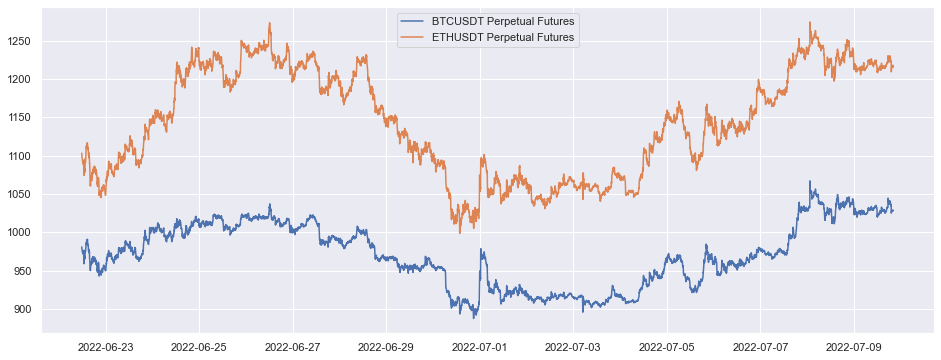

In [76]:
#ad-hoc downscaling
sns.set_style("darkgrid")
plt.figure(figsize=(16,6))
plt.plot(close_BTCPERP/21, label = 'BTCUSDT Perpetual Futures') 
plt.plot(close_ETHPERP, label = 'ETHUSDT Perpetual Futures')
plt.legend(loc = 'upper center')
plt.show()

In [48]:
logret_BTCPERP = pd.DataFrame(100 * np.diff(np.log(close_BTCPERP)))
logret_BTCPERP.columns = ['Log-returns']
logret_BTCPERP.index = close_BTCPERP.iloc[1:].index

logret_ETHPERP = pd.DataFrame(100 * np.diff(np.log(close_ETHPERP)))
logret_ETHPERP.columns = ['Log-returns']
logret_ETHPERP.index = close_ETHPERP.iloc[1:].index


In [49]:
RollingHourlyCorrelations = logret_BTCPERP.rolling(12).corr(logret_ETHPERP, ddof = 1, pairwise=False).dropna()

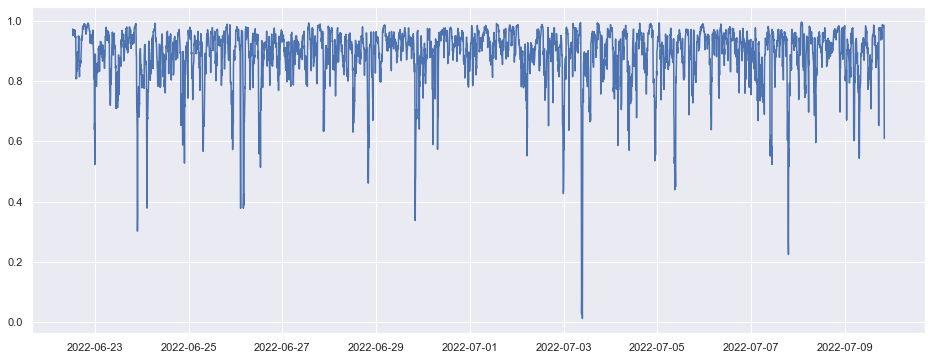

In [50]:
#Correlation does not imply causation. 
sns.set()
plt.figure(figsize=(16,6))
plt.plot(RollingHourlyCorrelations)
plt.show()

In [25]:
data = check_pair('BTC-PERP', 'ETH-PERP', '5m')

Cointegration: BTC-PERP ETH-PERP 0.0


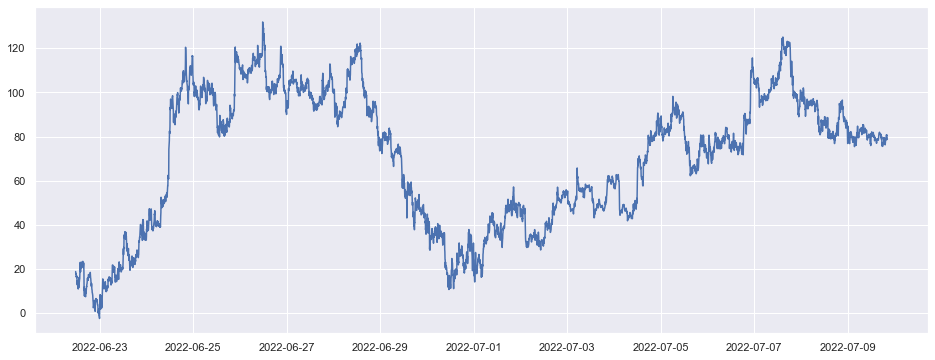

In [90]:
logSpread = np.log(close_BTCPERP) -  np.log(close_ETHPERP)

Spread = close_ETHPERP - 1/19 *  close_BTCPERP

plt.figure(figsize=(16,6))
#plt.plot(logSpread)
plt.plot(Spread)
plt.show()

In [102]:
import statsmodels.api as sm 
X = close_BTCPERP
X = sm.add_constant(close_BTCPERP)
reg = sm.OLS(close_ETHPERP, X)
reg = reg.fit()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [103]:
reg.params

const           -384.282084
close_BTCPERP      0.074892
dtype: float64

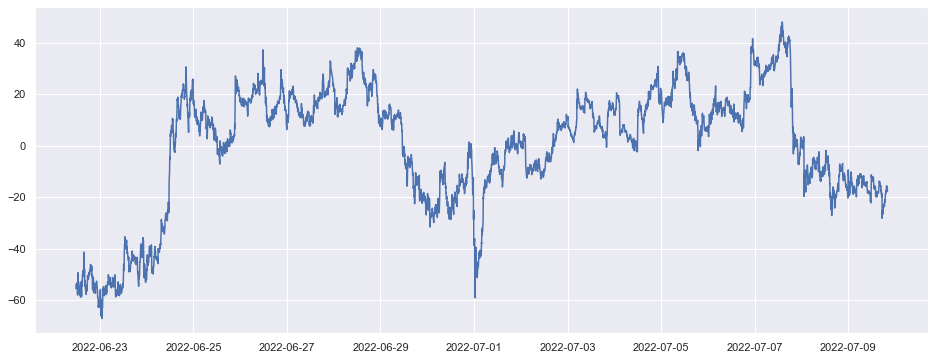

(23.750358276055845, 23.750358276055856)

In [112]:
EstimatedSpread = close_ETHPERP - reg.params[1] *  close_BTCPERP - reg.params[0]

plt.figure(figsize=(16,6))
#plt.plot(logSpread)
plt.plot(EstimatedSpread)
plt.show()
np.mean(close_ETHPERP - reg.params[1] *  close_BTCPERP ), reg.params[0]

np.std(reg.resid), np.std(close_ETHPERP - reg.params[1] *  close_BTCPERP)


- Cryptocurrency market is affected by same external events and thus ETH and BTC move in tangent with the exogenous events. 
- BTC is synonymous with cryptocurrency and there might be a lag from ETH. 
- The only divergence happens between BTC and/or ETH for single-coin specific events that only influences one of the coins. However, due to spillover-effects (good and bad) there might be a positive (allthough less extreme) move in the other coin. 
- Correlation does not imply causation, but correlation is a good intuitive indication that both cryptocurrencies influence oneanother.
-  